In [55]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

In [49]:
ratings_df = pd.read_csv('rating.csv')
anime_df = pd.read_csv('anime.csv') 

In [50]:
# Handle missing values in ratings dataset (e.g., removing rows with missing user_id or anime_id)
ratings_df.dropna(subset=['user_id', 'anime_id'], inplace=True)
# Drop duplicate entries in ratings_df
ratings_df.drop_duplicates(inplace=True)

In [51]:
# Handle missing values in anime dataset
anime_df.dropna(inplace=True)
# Replace 'Unknown' values with NaN in anime_df
anime_df.replace('Unknown', pd.NA, inplace=True)

# Drop rows with missing values in anime_df after replacing 'Unknown'
anime_df.dropna(inplace=True)


# Assuming 'ratings_df' contains duplicate entries based on 'user_id' and 'anime_id'
# You can aggregate the duplicate entries using mean rating as an example
ratings_df = ratings_df.groupby(['user_id', 'anime_id']).agg({'rating': 'mean'}).reset_index()
#ratings_df = ratings_df.sample(frac=0.05)
ratings_df = ratings_df[ratings_df['rating'] != -1]
# Group by 'anime_id' and count the number of unique users who rated each anime
anime_user_count = ratings_df.groupby('anime_id')['user_id'].nunique().reset_index(name='user_count')
# Group by 'user_id' and count the number of ratings for each user
user_ratings_count = ratings_df.groupby('user_id').size().reset_index(name='ratings_count')

# Filter users with more than 600 ratings
filtered_user_ids = user_ratings_count[user_ratings_count['ratings_count'] <= 500]['user_id'].tolist()

# Filter the ratings_df based on the filtered_user_ids
filtered_ratings_df = ratings_df[ratings_df['user_id'].isin(filtered_user_ids)]

ratings_df=filtered_ratings_df

# Filter animes rated by more than 15 users
filtered_anime_ids = anime_user_count[anime_user_count['user_count'] > 15]['anime_id'].tolist()

# Filter the ratings_df based on the filtered_anime_ids
filtered_ratings_df = ratings_df[ratings_df['anime_id'].isin(filtered_anime_ids)]
filtered_ratings_df.groupby('anime_id')['user_id'].nunique().reset_index(name='user_count')
ratings_df=filtered_ratings_df

In [52]:
ratings_df = pd.merge(ratings_df, anime_df[['anime_id', 'name']], on='anime_id', how='inner')

In [53]:
ratings_df.head()

,user_id,anime_id,rating,name
0,1,8074,10.0,Highschool of the Dead
1,1,11617,10.0,High School DxD
2,1,11757,10.0,Sword Art Online
3,1,15451,10.0,High School DxD New
4,2,11771,10.0,Kuroko no Basket


In [65]:
# Compute user-item matrix
#user_item_matrix = ratings_df.pivot(index='user_id', columns='anime_id', values='rating').fillna(0)

# Step 1: Group by user_id to count the number of ratings each user has given
user_ratings_count = ratings_df.groupby('user_id')['rating'].count()

# Step 2: Filter the top users with the most ratings
top_users = user_ratings_count.sort_values(ascending=False)[:3000].index

# Step 3: Group by name to count the number of ratings each anime has received
anime_ratings_count = ratings_df.groupby('name')['rating'].count()

# Step 4: Filter the top animes with the most ratings
top_animes = anime_ratings_count.sort_values(ascending=False)[:100].index

# Step 5: Filter the ratings DataFrame by the top users and top animes
filtered_ratings_df = ratings_df[ratings_df['user_id'].isin(top_users) & ratings_df['name'].isin(top_animes)]

# Step 6: Create the user-item matrix using pd.crosstab
user_item_matrix = pd.crosstab(filtered_ratings_df['user_id'], filtered_ratings_df['anime_id'], filtered_ratings_df['rating'], aggfunc=np.sum)
user_item_matrix.fillna(0, inplace=True)

C:\Users\kidus\AppData\Local\Temp\ipykernel_34348\2337386471.py:20: FutureWarning: The provided callable <function sum at 0x000002332CB736A0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  user_item_matrix = pd.crosstab(filtered_ratings_df['user_id'], filtered_ratings_df['anime_id'], filtered_ratings_df['rating'], aggfunc=np.sum)


In [66]:
# Compute user similarity matrix using cosine similarity
user_similarity = cosine_similarity(user_item_matrix)

In [67]:
# Convert user-item matrix to sparse format
from scipy.sparse import csr_matrix
user_item_sparse = csr_matrix(user_item_matrix)

In [68]:

# Initialize k-NN model for finding similar users
k = 10  # Number of nearest neighbors
knn = NearestNeighbors(n_neighbors=k, metric='cosine', algorithm='brute')
knn.fit(user_item_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

In [69]:
def predict_rating(user_id, anime_id):
    # Find similar users for the target user
    user_idx = user_item_matrix.index.get_loc(user_id)
    distances, indices = knn.kneighbors(user_item_matrix.iloc[user_idx].values.reshape(1, -1))

    # Get ratings of similar users for the target anime
    similar_users_ratings = user_item_matrix.iloc[indices[0], user_item_matrix.columns.get_loc(anime_id)]

    # Calculate weighted average of ratings as prediction
    prediction = similar_users_ratings.mean()

    return prediction

In [73]:
# Example usage:
target_user_id = 5  # Replace with the ID of the target user
target_anime_id = 6  # Replace with the ID of the target anime
predicted_rating = predict_rating(target_user_id, target_anime_id)
print(f"Predicted rating for user {target_user_id} on anime {target_anime_id}: {predicted_rating:.2f}")

Predicted rating for user 5 on anime 6: 8.10


In [70]:
print(user_item_matrix.index.unique())

Index([    5,     7,    17,    46,   123,   160,   210,   248,   256,   321,
       ...
       73343, 73346, 73359, 73379, 73380, 73389, 73406, 73417, 73422, 73457],
      dtype='int64', name='user_id', length=2999)


In [71]:
print(user_item_matrix.columns.unique())


Index([    1,     6,    20,    30,    59,    71,   120,   121,   164,   199,
         205,   223,   225,   226,   227,   269,   270,   355,   356,   430,
         431,   523,   813,   849,   853,   889,   934,  1195,  1535,  1575,
        1689,  1818,  1840,  1887,  2001,  2025,  2167,  2236,  2251,  2476,
        2904,  2966,  2993,  3457,  3588,  4181,  4224,  4654,  4752,  4898,
        5081,  5114,  5630,  5680,  6045,  6347,  6547,  6702,  6746,  6880,
        7054,  8074,  8525,  8769,  8841,  9253,  9756,  9919,  9989, 10087,
       10620, 10719, 10793, 11111, 11617, 11741, 11757, 11759, 11771, 12189,
       13601, 13759, 14227, 14345, 14741, 14813, 15809, 16498, 17265, 18153,
       18679, 19815, 20507, 21881, 22199, 22319, 22535, 27899, 28223, 30276],
      dtype='int64', name='anime_id')


In [74]:
import matplotlib.pyplot as plt

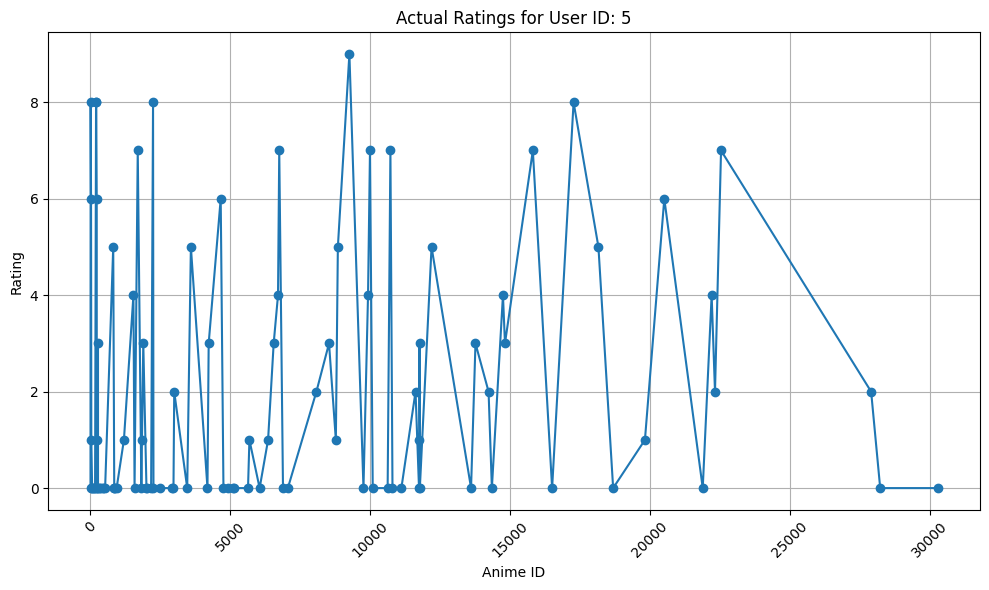

In [77]:
# Assuming you have the user-item matrix named user_item_matrix and a specific user_id
user_id = 5

# Get the actual ratings for the specified user_id from the user-item matrix
user_ratings = user_item_matrix.loc[user_id]

# Plot the actual ratings for the specified user_id
plt.figure(figsize=(10, 6))
plt.plot(user_ratings, marker='o', linestyle='-')
plt.xlabel('Anime ID')
plt.ylabel('Rating')
plt.title(f'Actual Ratings for User ID: {user_id}')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
def plot_actual_vs_predicted(user_id):
    # Initialize lists to store actual and predicted ratings
    actual_ratings = []
    predicted_ratings = []

    # Iterate through each anime_id in the user_item_matrix
    for anime_id in user_item_matrix.columns:
        # Get the actual rating for the specified user_id and anime_id
        actual_rating = user_item_matrix.loc[user_id, anime_id]
        # Predict the rating for the specified user_id and anime_id
        predicted_rating = predict_rating(user_id, anime_id)

        # Append actual and predicted ratings to the respective lists
        actual_ratings.append(actual_rating)
        predicted_ratings.append(predicted_rating)

    # Plot the actual vs predicted ratings
    plt.figure(figsize=(10, 6))
    plt.plot(actual_ratings, label='Actual Ratings', marker='o')
    plt.plot(predicted_ratings, label='Predicted Ratings', marker='x')
    plt.xlabel('Anime ID')
    plt.ylabel('Rating')
    plt.title(f'Actual vs Predicted Ratings for User {user_id}')
    plt.legend()
    plt.grid(True)
    plt.show()


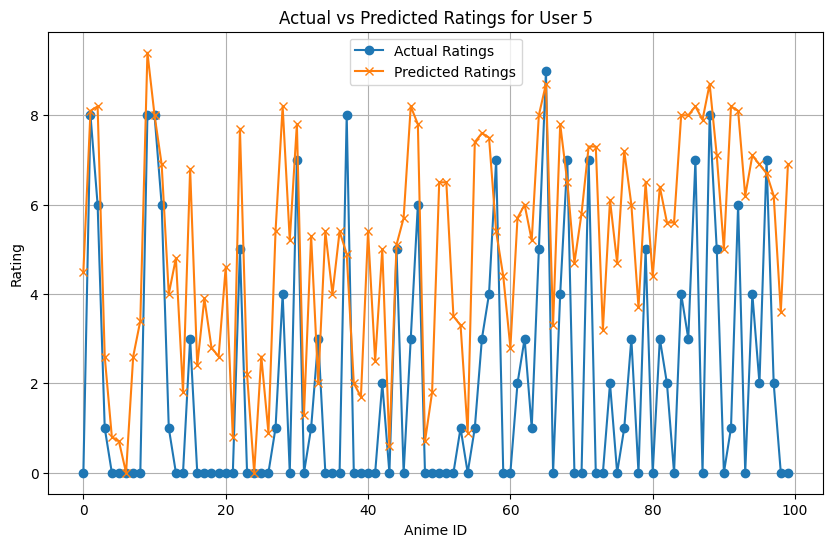

In [82]:
plot_actual_vs_predicted(5)

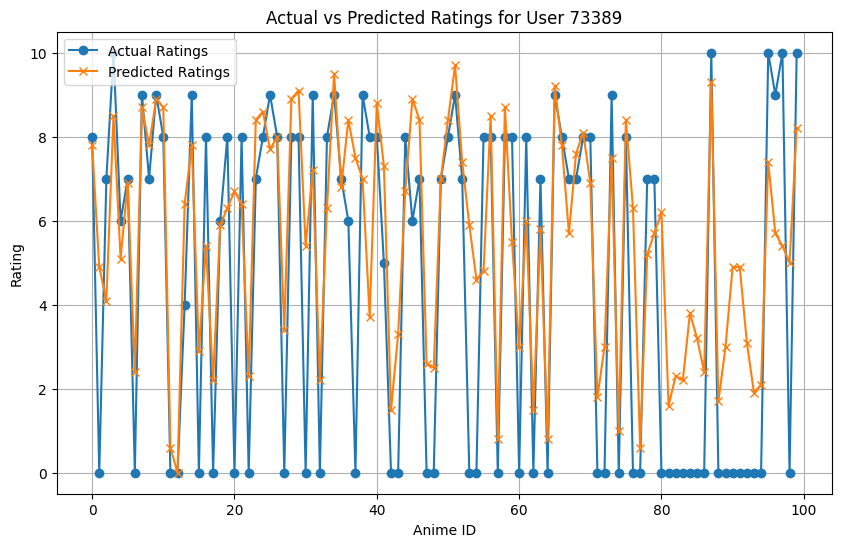

In [84]:
plot_actual_vs_predicted(73389)